In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from data_loaders.CUB_200_2011 import CUB200Dataset
from models import get_gmodel
from ganlib.priors import get_sampler_fn
from pathlib import Path
import yaml
from easydict import EasyDict as edict
from PIL import Image
import pickle

## Loading Model

In [2]:
model_folder = Path("logs/EfficientGAN_96[ICJNN.exp1][AttnG.Interp.ttur]_CUB_0114_1725")
epoch = 440
with open(model_folder / 'config.yaml', 'r') as f:
        params = yaml.load(f)
        config = edict(params)
device = torch.device('cpu') # 'cuda' for GPU
m = torch.load(model_folder / "netG_avg_epoch_{}.pth".format(epoch),
                map_location=lambda storage, loc: storage)
netG = get_gmodel(**m['netG_params'])
netG.load_state_dict(m['net'])
netG = netG.eval().to(device)
sampler_fn = get_sampler_fn(config.prior, device=device,
                                normalize=config.normalize_prior)

/home/douglas/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


## Load Dataset
-------------
We need to get text embeddings and to get real images if we want to compare

In [3]:
tform =transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])


dset = CUB200Dataset('datasets/CUB_200_2011/birds',
                        tform, None, split='test',
                        return_captions=True, return_fnames=True)

## Showing a real image from the test set

fname: 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18 fix: 0 cap idx: 0 caption: light tan colored bird with a white head and an orange beak.



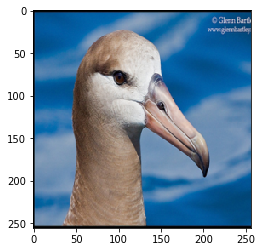

In [4]:
cap_idx = 0 # from 0 to 9

img, embs, caption, fname, fix = dset[0] # test instance idx
embs = embs.squeeze(0)[cap_idx]
emb = torch.tensor(embs[None, ...], dtype=torch.float32)
cap = caption[cap_idx]
print('fname:', fname, 'fix:', fix, 'cap idx:', cap_idx, 'caption:', cap)
img = img.mul(0.5).add(0.5).clamp(0, 1).mul(255).clamp_(0, 255).byte().permute(1, 2, 0).cpu().numpy()
plt.imshow(img)
plt.show()

## Generating an image from the description above

In [5]:
z = sampler_fn(1, config.z_dim)

In [6]:
with torch.no_grad():
    imgs = netG(z.to(device), emb.to(device))
    img = imgs[0].mul(0.5).add(0.5).clamp(0, 1).mul(255).clamp_(0, 255).byte().permute(1, 2, 0).cpu().numpy()

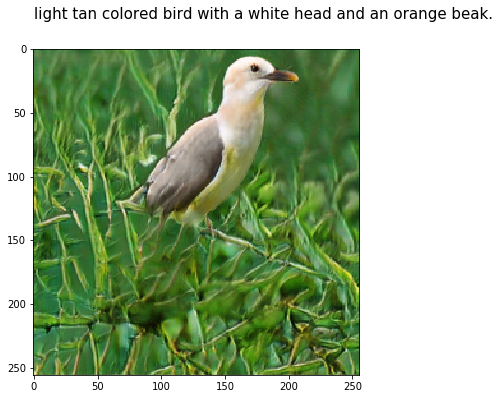

In [7]:
fig = plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.text(0, -10, cap, fontsize=15)
plt.show()

## Generating multiple images for a single caption

In [8]:
batch_size = 8 # number of images to generate
z = sampler_fn(batch_size, config.z_dim)

(8, 256, 256, 3)
light tan colored bird with a white head and an orange beak.



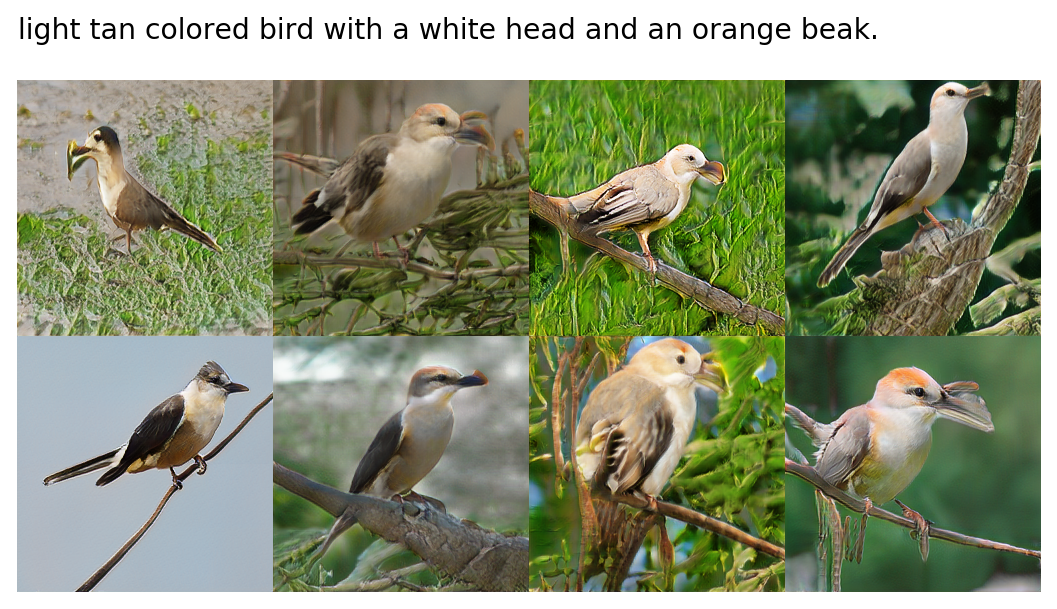

In [9]:
with torch.no_grad():
    imgs = netG(z.to(device), emb.to(device).repeat(batch_size, 1))
    imgs = imgs.mul(0.5).add(0.5).clamp(0, 1).mul(255).clamp_(0, 255).byte().permute(0, 2, 3, 1).cpu().numpy()
print(imgs.shape)

mydpi=170.

print(cap)
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=((256*4./mydpi), (256*2./mydpi)), dpi=mydpi)
axes.ravel()[0].text(0, -10, cap, fontsize=12)
for ii, ax in zip(range(batch_size), axes.flatten()):
    ax.imshow(imgs[ii], aspect='equal')
    ax.set_axis_off()
plt.subplots_adjust(bottom=0, top=1, left=0, right=1, wspace=0, hspace=0)
plt.show()